In [10]:
# ! pip install streamlit
! pip install plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from datetime import timedelta
import plotly.express as px
import sqlite3

pd.set_option('display.max_columns', 40)
# display max rows 75
pd.set_option('display.max_rows', 75)

# nombre de sessions de lecture

In [8]:
# Charger le DataFrame
df_book_updated = pd.read_parquet("../data_sources_from_python/df_book_updated.parquet")
df_stat = pd.read_parquet("../data_sources_from_python/stats_lecture.parquet")

In [ ]:
import pandas as pd

# Charger le fichier parquet


# Convertir les colonnes liées au temps en format datetime
# Convertir les colonnes liées au temps en format datetime
df_stat['heure de début'] = pd.to_datetime(df_stat['heure de début'])
df_stat['date de fin de lecture'] = pd.to_datetime(df_stat['date de fin de lecture'])


# Trier les logs par "heure de début"
df_stat = df_stat.sort_values(by='heure de début')

# Calculer la différence de temps entre les logs consécutifs
df_stat['diff_minutes'] = df_stat['heure de début'].diff().dt.total_seconds() / 60

# Définir un seuil pour les sessions (10 minutes)
session_threshold = 15
df_stat['session_id'] = (df_stat['diff_minutes'] > session_threshold).cumsum()

# Regrouper par session
sessions = df_stat.groupby('session_id').agg({
    'id_book': 'first',  # ID du livre
    'heure de début': 'min',  # Début de la session
    'date de fin de lecture': 'max',  # Fin de la session
    'Temps passé sur la page en seconde': 'sum',  # Temps total passé
    'page': ['min', 'max'],  # Pages lues
    'id_long': 'first'  # ID unique du livre
})

# Renommer les colonnes pour plus de clarté
sessions.columns = ['_'.join(col).strip() for col in sessions.columns]
sessions = sessions.reset_index()

# Afficher le résultat
sessions.head()


,session_id,id_book_first,heure de début_min,date de fin de lecture_max,Temps passé sur la page en seconde_sum,page_min,page_max,id_long_first
0,0,1,2023-11-21 20:26:32,2023-11-21,54,1,8,00001
1,1,2,2023-11-21 20:41:41,2023-11-27,397,5,11,00002
2,2,2,2023-11-21 21:49:15,2023-11-27,99,11,19,00002
3,3,2,2023-11-21 22:34:59,2023-11-27,1480,20,49,00002
4,4,2,2023-11-22 12:53:22,2023-11-27,405,50,65,00002


In [14]:
sessions_with_titles = sessions.merge(
    df_book_updated[['id', 'Titre']],  # On garde uniquement les colonnes nécessaires
    left_on='id_book_first',          # Clé de jointure depuis sessions
    right_on='id',                    # Clé de jointure depuis df_book_updated
    how='left'                        # Jointure à gauche pour garder toutes les sessions
)

# Supprimer la colonne 'id' de df_book_updated après la jointure si non nécessaire
sessions_with_titles.drop(columns=['id'], inplace=True)

# Afficher le résultat
sessions_with_titles.head()

,session_id,id_book_first,heure de début_min,date de fin de lecture_max,Temps passé sur la page en seconde_sum,page_min,page_max,id_long_first,Titre
0,0,1,2023-11-21 20:26:32,2023-11-21,54,1,8,00001,NaN
1,1,2,2023-11-21 20:41:41,2023-11-27,397,5,11,00002,Le crime de l'Orient-Express
2,2,2,2023-11-21 21:49:15,2023-11-27,99,11,19,00002,Le crime de l'Orient-Express
3,3,2,2023-11-21 22:34:59,2023-11-27,1480,20,49,00002,Le crime de l'Orient-Express
4,4,2,2023-11-22 12:53:22,2023-11-27,405,50,65,00002,Le crime de l'Orient-Express


C:\Users\chric\AppData\Local\Temp\ipykernel_12464\2861101892.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_sessions['heure_debut_sec'] = dec_sessions['heure de début_min'].dt.time.apply(time_to_seconds)
C:\Users\chric\AppData\Local\Temp\ipykernel_12464\2861101892.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_sessions['heure_fin_sec'] = dec_sessions['heure de fin'].dt.time.apply(time_to_seconds)


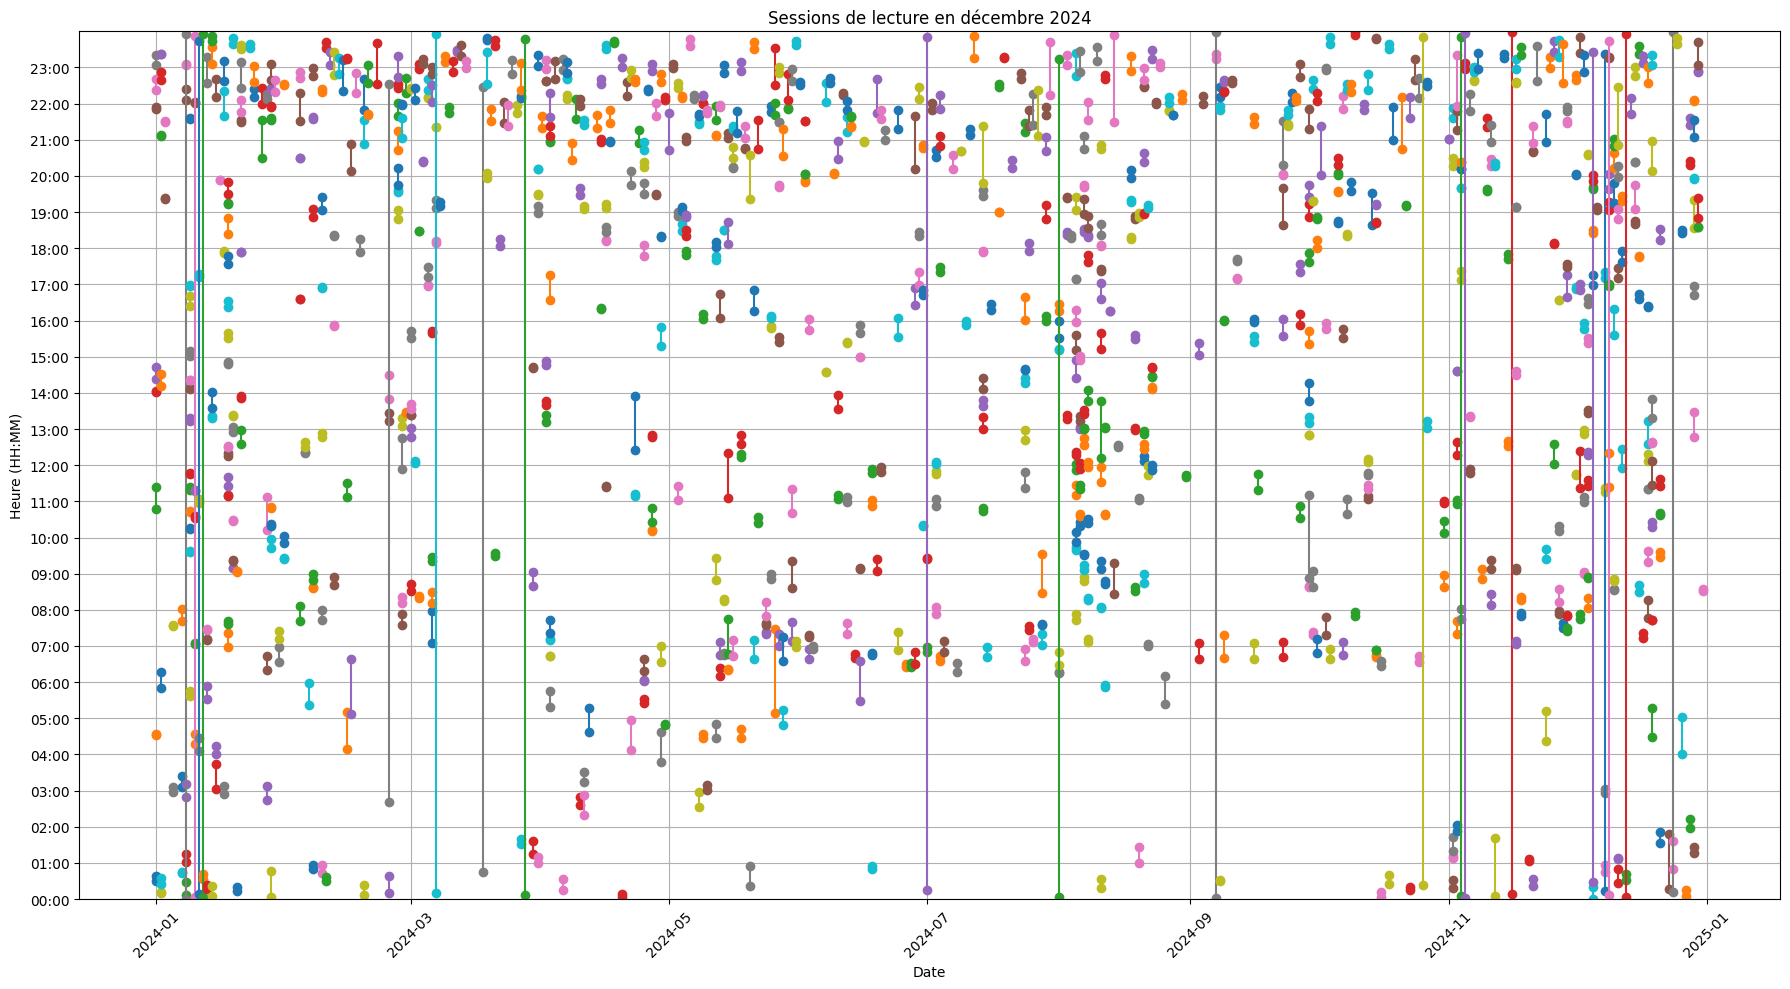

In [22]:
# Ajouter une colonne pour l'heure de fin basée sur l'heure de début et le temps passé
sessions_with_titles['heure de fin'] = sessions_with_titles['heure de début_min'] + pd.to_timedelta(sessions_with_titles['Temps passé sur la page en seconde_sum'], unit='s')

# Filtrer pour le mois de décembre 2024
dec_sessions = sessions_with_titles[sessions_with_titles['heure de début_min'].dt.year == 2024]
# dec_sessions = dec_sessions[dec_sessions['heure de début_min'].dt.month == 12]

# Utiliser une date de référence pour calculer les secondes depuis minuit
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

# Conserver les heures sous forme de secondes depuis le début de la journée pour affichage
dec_sessions['heure_debut_sec'] = dec_sessions['heure de début_min'].dt.time.apply(time_to_seconds)
dec_sessions['heure_fin_sec'] = dec_sessions['heure de fin'].dt.time.apply(time_to_seconds)

# Plotting
plt.figure(figsize=(18, 10))
for idx, row in dec_sessions.iterrows():
    plt.plot([row['heure de début_min'].date(), row['heure de début_min'].date()], 
             [row['heure_debut_sec'], row['heure_fin_sec']], 
             marker='o')

# Configuration des étiquettes et des limites de l'axe des Y
ticks = [i * 3600 for i in range(24)]
labels = [f'{i:02d}:00' for i in range(24)]

plt.yticks(ticks, labels)
plt.ylim(0, 24 * 3600 - 1)

plt.title('Sessions de lecture en décembre 2024')
plt.xlabel('Date')
plt.ylabel('Heure (HH:MM)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# sQLITE3

Utiliser les tables parquets déjà dans le dossier data_sources_pyhon et pas la connection à sqlite3

In [ ]:

# # check des tables
# # Chemin vers SQLite, depuis le répertoire "update"
# database_path = "../sqlite/update/statistics.sqlite3"


# # Connexion à la base de données SQLite
# conn = sqlite3.connect(database_path)

# # Liste toutes les tables de la base de données
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# tables = pd.read_sql(query, conn)

# # Charger une table de la base de données dans un df pandas
# book = 'book'
# df_book_new = pd.read_sql(f"SELECT * FROM {book};", conn)
# sqlite_sequence = 'sqlite_sequence'
# sqlite_sequence_table = pd.read_sql(f"SELECT * FROM {sqlite_sequence};", conn)
# numbers = 'numbers'
# numbers_table = pd.read_sql(f"SELECT * FROM {numbers};", conn)
# page_stat_data = "page_stat_data"
# df_page_stat_data = pd.read_sql(f"SELECT * FROM {page_stat_data};", conn)
# # print le nombre de ligne de df_book_new
# print("Nombre de lignes de df_book_new : ", df_book_new.shape[0])
# # print le nombre de ligne de df_page_stat_data
# print("Nombre de lignes de df_page_stat_data : ", df_page_stat_data.shape[0])

# # fermer de la connexion à la base de données
# conn.close()

Nombre de lignes de df_book_new :  60
Nombre de lignes de df_page_stat_data :  20085


In [ ]:
# print(tables)

              name
0             book
1  sqlite_sequence
2   page_stat_data
3          numbers


Pour reprendre en route, possible de récupérer directement la verion du dataset depuis les fichiers parquets

In [3]:
# df_book = pd.read_parquet('df_book.parquet')
df_book_updated = pd.read_parquet('../data_sources_from_python/df_book_updated.parquet')
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet('../data_sources_from_python/stats_lecture.parquet')


In [4]:
df_stat.sort_values(by='heure de début', ascending=False).head(5)

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture
20387,79,21,2024-12-01 11:44:20,74,515,00079,1.233333,0.020556,2024-12-01,11:44:20,11,11.733333,2024-11-30,False,2024-12-01
20386,79,20,2024-11-29 21:54:04,26,515,00079,0.433333,0.007222,2024-11-29,21:54:04,21,21.900000,2024-11-28,True,2024-12-01
20385,79,19,2024-11-29 21:53:57,7,515,00079,0.116667,0.001944,2024-11-29,21:53:57,21,21.883333,2024-11-28,True,2024-12-01
20384,79,18,2024-11-29 21:53:16,41,515,00079,0.683333,0.011389,2024-11-29,21:53:16,21,21.883333,2024-11-28,True,2024-12-01
20383,79,17,2024-11-29 21:52:45,31,515,00079,0.516667,0.008611,2024-11-29,21:52:45,21,21.866667,2024-11-28,True,2024-12-01


# visuel 1 : table avec la liste des livres lus dans l'année. --> DONE
## step 1 : easy
* trié du plus récent au plus ancien 
* uniquement les livres lus en entier

## step 2 : 
* Récupérer le nombre de jour de lecture pour chaque livre 
* calculer le nombre de pages lues par jour de lecture
* calculer le nombre d'heures de lecture par jour de lecture
* calculer la vitesse de lecture : page /min

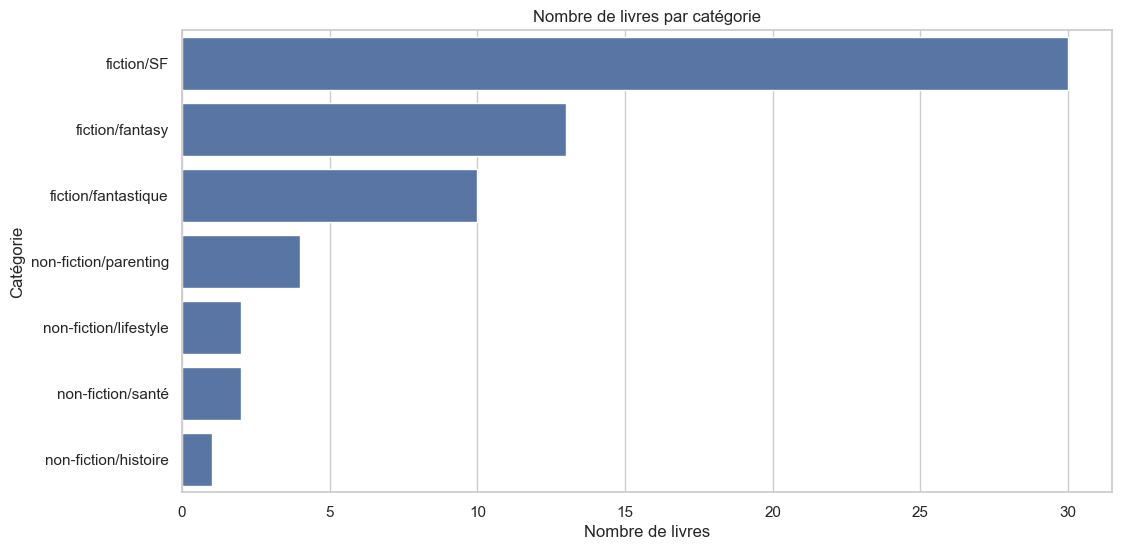

In [6]:
# plot avec seaborn en bar chhat le nombre de livre par categorie

#TODO 1 couleur par categorie principale "fiction" ou "non-fiction"


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='Catégorie', data=df_book_updated, order=df_book_updated['Catégorie'].value_counts().index)
plt.title('Nombre de livres par catégorie')
plt.xlabel('Nombre de livres')
plt.ylabel('Catégorie')
plt.show()

In [7]:
# Calculer le nombre de livres par catégorie
category_counts = df_book_updated['Catégorie'].value_counts().reset_index()
category_counts.columns = ['Catégorie', 'nombre de livre']
category_counts_sorted = category_counts.sort_values(by='nombre de livre', ascending=True)

# Créer un graphique à barres horizontal
fig = px.bar(category_counts_sorted,
             x='nombre de livre', 
             y='Catégorie',
             orientation='h',  # 'h' indique un bar chart horizontal
             title='Nombre de livres par catégorie',
             labels={'nombre de livre': 'Nombre de livres', 'Catégorie': 'Catégories'})

# Afficher le graphique
fig.show()

# visuel 2
heatmap heure de lecture et calendrier
https://plotly.com/python/heatmaps/
A retravailler mais on est pas loin


sinon : 
https://python.plainenglish.io/interactive-calendar-heatmaps-with-plotly-the-easieast-way-youll-find-5fc322125db7
Mais ça rend moche

In [ ]:
# ! pip install plotly_calplot 

  Attempting uninstall: pytz
    Found existing installation: pytz 2024.2
    Uninstalling pytz-2024.2:
      Successfully uninstalled pytz-2024.2



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
from plotly_calplot import calplot


# prendre uniquement les données de 2024 date de lecture
df_stat2 = df_stat[df_stat['heure de début'].dt.year == 2024]


fig = calplot(df_stat2, x="date lecture", y="Temps de lecture en minute")
fig.show()

d:\6.dev\book_data_analysis\.venv\Lib\site-packages\plotly_calplot\calplot.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
! pip install calmap


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\chric\AppData\Local\Temp\ipykernel_14868\1789621246.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



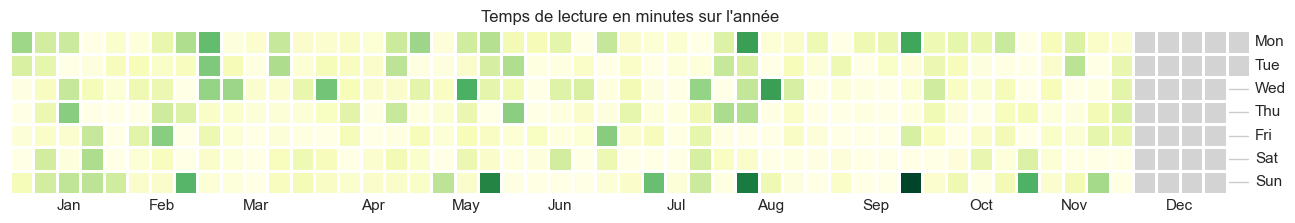

In [ ]:
import calmap
import matplotlib.pyplot as plt
# passer df_stat2['date lecture'] en dt time
df_stat2['date lecture'] = pd.to_datetime(df_stat2['date lecture'])
df_aggregated = df_stat2.groupby('date lecture')['Temps de lecture en minute'].sum().reset_index()
df_serie = df_aggregated.set_index('date lecture')['Temps de lecture en minute']

# Remplir les dates manquantes avec 0
df_serie = df_serie.asfreq('D', fill_value=0)



plt.figure(figsize=(16, 10))
calmap.yearplot(
    df_serie,
    year=df_serie.index.year[0],
    fillcolor='lightgrey',
    cmap='YlGn',
    linewidth=2,
    dayticks = True
    )

plt.title('Temps de lecture en minutes sur l\'année')
plt.show()


# 3 score card
* plus longue lecture : heure de lecture max
* le plus régulier : jour de lecture = intervalle de lecture
* plus rapide : page lues à la minute
* plus addictif : pages lues par jour

## plus longue lecture

In [9]:
# le temps de lecture max
temps_maxi = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]

# prisme livre
titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Titre"].values[0]
auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["temps passé sur le livre en heure"] == df_book_streamlit["temps passé sur le livre en heure"].max()]["Auteurs"].values[0]
temps_max_lecture = df_book_streamlit["temps passé sur le livre en heure"].max()


print(f"Livre le plus long à lire : {titre_max_temps_lecture} de {auteur_max_temps_lecture} : {temps_max_lecture}")


Livre le plus long à lire : La Chute d'Hypérion: Le cycle d'Hypérion - Tome 2 de Dan Simmons : 13.3


## plus régulier
Trop de livre dans cette liste

In [50]:
# Afficher les livres ou la durée de lecture est égale à la durée de lecture effective
# df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]][["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)"]]

# Compter le nombre de lignes où "jours de lecture effectifs (jl)" est égal à "Durée lecture (j)"
count = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].shape[0]

# affiche le dernier, puis l'avant dernier, puis l'avant avant dernier
df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending
=False).head(3)[["Titre", "Durée lecture (j)", "jours de lecture effectifs (jl)", "Date de lecture"]]
# enregistre les 3 titres dans une liste
liste_livres = df_book_streamlit[df_book_streamlit["jours de lecture effectifs (jl)"] == df_book_streamlit["Durée lecture (j)"]].sort_values(by="Date de lecture", ascending   =False).head(3)["Titre"].values


print(f"{count} livres lus tous les jours, les 3 derniers : {liste_livres}")


27 livres lus tous les jours, les 3 derniers : ["Projet secret T2 : Manuel de Survie du Sorcier Frugal dans l'Angleterre médiévale"
 'Voyageur 2 : Libration'
 "Blackwater 1 - La crue: L'épique saga de la famille Caskey"]


## le plus rapide
Utiliser le df non filtré

In [55]:
livre_rapide = df_book_updated[df_book_updated["temps passé sur le livre en minute"] > 35]
livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]

titre_livre_rapide = livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Titre"].values[0]
auteur_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["Auteurs"].values[0]
vitesse_livre_rapide =livre_rapide[livre_rapide["pages lues à la minute"] == livre_rapide["pages lues à la minute"].max()]["pages lues à la minute"].values[0].round(1)


# titre_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Titre"].values[0]
# auteur_max_temps_lecture = df_book_streamlit[df_book_streamlit["Temps de lecture total (hh:mm:ss)"] == df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()]["Auteurs"].values[0]
# temps_max_lecture = df_book_streamlit["Temps de lecture total (hh:mm:ss)"].max()



print(f"Livre lu avec la vitessse max : {titre_livre_rapide} de {auteur_livre_rapide} à {vitesse_livre_rapide} pages à la minute")



Livre lu avec la vitessse max : la route de Cormac McCarthy à 2.0 pages à la minute


## plus addictif : max moyenne pages lues par jour

In [56]:
livre_addict = df_book_updated[df_book_updated["minutes_lecture_par_jour_de_lecture"] == df_book_updated["minutes_lecture_par_jour_de_lecture"].max()]
titre_livre_addict = livre_addict["Titre"].values[0]
auteur_livre_addict = livre_addict["Auteurs"].values[0]
minutes_livre_addict = livre_addict["minutes_lecture_par_jour_de_lecture"].values[0]

print(f"Livre lu avec la moyenne de temps de lecture par jour la plus élevée : {titre_livre_addict} de {auteur_livre_addict} avec {minutes_livre_addict} minutes de lecture par jour")

Livre lu avec la moyenne de temps de lecture par jour la plus élevée : la route de Cormac McCarthy avec 93.7 minutes de lecture par jour


## les stats depuis le prisme inversé : pic de vitesse (date et livre), page lu en 1 journée (date et livre), heure de lecture max en 1 journée (date et livre)

### 1. Heure de lecture max dans la journée

Solution : 

Faire un group by, date lecture : 
* sum : temps passé sur la page
* sum id_book
* concatenate la liste des id_book de chaque ligne ? (ou les titres de livre directement)


--> Permet d'identifier le jour avec le plus longtemps en lecture, et les livres identifiés

In [110]:
# Convertir la colonne 'date lecture' en datetime
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'], format='%Y-%m-%d')

# Joindre df_stat avec df_book_updated pour inclure le nom des livres
df_stat2 = df_stat.merge(df_book_updated, left_on='id_book', right_on='id', how='left')

# Agréger les données par 'date lecture'
agg_data = df_stat2.groupby('date lecture').agg({
    'Temps de lecture en minute': 'sum',
    'page': 'nunique',
    'id_book': 'nunique'
}).reset_index()

# Ajouter la liste des id_book et des titres pour chaque date de lecture
book_ids_titles_by_date = df_stat2.groupby('date lecture').apply(
    lambda x: ', '.join(sorted(set(f"{row['id_book']} ({row['Titre']})" for _, row in x.iterrows())))
).reset_index()

# Fusionner les deux DataFrames
merged_data = pd.merge(agg_data, book_ids_titles_by_date, on='date lecture')

# Renommer pour plus de clarté
merged_data.columns = ['date lecture', 'Temps de lecture en minute', 'Nombre de pages', 'Nombre de livres', 'Books']

# Afficher le résultat
print(merged_data)

    date lecture  Temps de lecture en minute  Nombre de pages  \
0     2012-05-01                   36.900000               52   
1     2023-11-21                   33.833333               40   
2     2023-11-22                   21.166667               36   
3     2023-11-23                   91.300000              160   
4     2023-11-24                    9.500000               11   
..           ...                         ...              ...   
265   2024-11-02                   69.783333               92   
266   2024-11-03                  175.100000              237   
267   2024-11-04                   36.633333               69   
268   2024-11-05                   22.150000               31   
269   2024-11-06                    9.816667               15   

     Nombre de livres                                              Books  
0                   2  57 (Légendes et lattes), 58 (Roman secret 3 - ...  
1                   2          1 (nan), 2 (Le crime de l'Orient-Expre

C:\Users\chric\AppData\Local\Temp\ipykernel_21332\33408628.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
# print les 10 premières lignes, triées par 'Temps de lecture en minute' de manière décroissante
merged_data.sort_values('Temps de lecture en minute', ascending=False).head(3)

NameError: name 'merged_data' is not defined

### Pic de vitesse : 

Pic par heure et livres associés

In [114]:
# Ajouter les colonnes 'id_book' et 'Titre' avec valeurs uniques pour chaque groupe
def concatenate_unique_values(series):
    return ', '.join(sorted(set(map(str, series))))

books_info = df_stat2.groupby(['date lecture', 'Heure']).apply(
    lambda x: pd.Series({
        'id_books': concatenate_unique_values(x['id_book']),
        'Titres': concatenate_unique_values(x['Titre'])
    })
).reset_index()

# Fusionner les deux DataFrames
result = pd.merge(agg_data_pic_vitesse, books_info, on=['date lecture', 'Heure'])

# Renommer les colonnes pour plus de clarté (si nécessaire)
result.columns = ['date lecture', 'Heure', 'Nombre de pages', 'Temps passé sur la page en seconde', 'Temps de lecture en minute', 'id_books', 'Titres']

# Afficher le ré

C:\Users\chric\AppData\Local\Temp\ipykernel_21332\2549705109.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
result["page à la minute"] = (result["Nombre de pages"] / (result["Temps de lecture en minute"] )).round(2) 

# faire un head de result trié par page à la minute, uniquement quand page supérieur à 60
result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(5)
# result.sort_values(by='page', ascending=False).head(10)

,date lecture,Heure,Nombre de pages,Temps passé sur la page en seconde,Temps de lecture en minute,id_books,Titres,page à la minute
240,2024-02-28,21,79,2123,35.383333,25,Le manuel de survie des parents,2.23
281,2024-03-19,0,100,2736,45.600000,32,la route,2.19
455,2024-05-21,16,73,2046,34.100000,39,Skyward T3 : Cytonique,2.14
451,2024-05-20,19,71,2037,33.950000,39,Skyward T3 : Cytonique,2.09
17,2023-11-23,12,63,1821,30.350000,2,Le crime de l'Orient-Express,2.08
599,2024-07-24,16,79,2336,38.933333,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.03
612,2024-07-28,9,78,2306,38.433333,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.03
608,2024-07-27,21,106,3166,52.766667,58,Roman secret 3 - Yumi et le peintre de cauchemars,2.01
280,2024-03-18,23,117,3593,59.883333,32,la route,1.95
772,2024-09-29,9,110,3407,56.783333,67,Voyageur 1 : L'Espace d'un an,1.94


<Axes: xlabel='Heure', ylabel='count'>

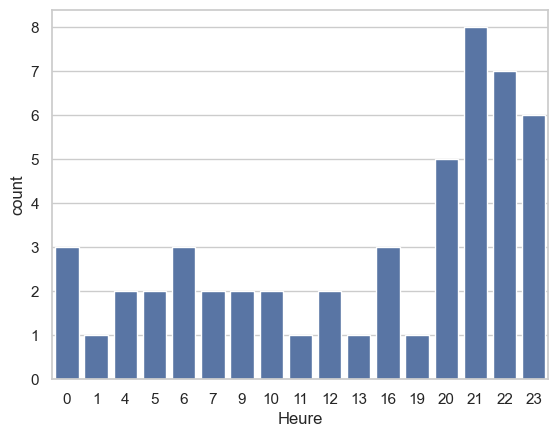

In [119]:
# plot le nombre de fois où chaque heure apparait pour "result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(100)"
sns.countplot(x='Heure', data=result[result["Nombre de pages"] > 60].sort_values(by='page à la minute', ascending=False).head(100))

### nombre d'auteurs et nombres de livres lus

In [123]:
# print le nombre de lignes de df_book_updated
nb_livres_lus = df_book_streamlit.shape[0]
# print le nombre d'Auteurs lus de df_book_updated
nb_auteurs_lus = df_book_streamlit["Auteurs"].nunique()


print(f"{nb_livres_lus} livres lus, de {nb_auteurs_lus} auteurs différents")

56 livres lus, de 38 auteurs différents


# MATRICE PYTHON --> DONE

Exemple : 

In [3]:
# Créer une matrice 3x3 avec des étiquettes (labels)
data = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

# Définir les noms des colonnes et des index (lignes)
columns = ['A', 'B', 'C']
index = ['R1', 'R2', 'R3']

# Créer le DataFrame
df = pd.DataFrame(data, columns=columns, index=index)

print(df)

    A  B  C
R1  1  2  3
R2  4  5  6
R3  7  8  9


In [3]:
df_book_updated = pd.read_parquet("../data_sources_from_python/df_book_updated.parquet")
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet("../data_sources_from_python/stats_lecture.parquet")
# préparer df_book_updated pour le filtre : 
df_book_updated['Date de lecture'] = pd.to_datetime(df_book_updated['Date de lecture'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df_stat['Date de lecture en jour'] = pd.to_datetime(df_stat['date lecture'], format="%Y-%m-%d")

## Temps de lecture quotidien moyen

In [ ]:
# ===== MATRICE =====

# TEMPS DE LECTURE MOYEN

# Temps de lecture moyen par jour, distinct date de lecture en jour
temps_quotidien_moyen_ALL = df_stat["Temps passé sur la page en seconde"].sum() / df_stat["Date de lecture en jour"].nunique()/60 # c'est faux, il faudrait group by si c'est pour utilser mean
# Temps de lecture dernier jour (df_stat)
temps_quotidien_moyen_lastday = df_stat[df_stat["Date de lecture en jour"] == df_stat["Date de lecture en jour"].max()]["Temps passé sur la page en seconde"].sum()/60

# temps de lecture 3 derniers jours (df_stat)
temps_quotidien_moyen_3days_sum = (df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)]["Temps passé sur la page en seconde"].sum()/60).round(0)
temps_quotidien_moyen_3days = (df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)]["Temps passé sur la page en seconde"].sum()/60/3).round(0)
temps_quotidien_moyen_7days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)]["Temps passé sur la page en seconde"].sum()/60
temps_quotidien_moyen_7days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)]["Temps passé sur la page en seconde"].sum()/60/7
temps_quotidien_moyen_30days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)]["Temps passé sur la page en seconde"].sum()/60
temps_quotidien_moyen_30days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)]["Temps passé sur la page en seconde"].sum()/60/30
temps_quotidien_moyen_365days_glissants_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)]["Temps passé sur la page en seconde"].sum()/60
temps_quotidien_moyen_365days_glissants = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)]["Temps passé sur la page en seconde"].sum()/60/365
temps_quotidien_moyen_this_year_sum = df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year]["Temps passé sur la page en seconde"].sum()/60
temps_quotidien_moyen_this_year = df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year]["Temps passé sur la page en seconde"].sum()/60/df_stat["Date de lecture en jour"].nunique()





# NOMBRE DE PAGE MOYEN
# faire un group by de df_stat par id_book et page
df_stat_grouped_nb_pages = df_stat.groupby(["id_book", "page"]).size().reset_index(name='count')
nombre_de_lignes = df_stat_grouped_nb_pages.shape[0]
pages_quotidien_moyen_ALL = nombre_de_lignes / df_stat["Date de lecture en jour"].nunique() # compte que les jours de lecture
pages_hebdo_moyen_ALL = nombre_de_lignes / df_stat["Date de lecture en jour"].nunique() * 7
pages_monthly_moyen_ALL = nombre_de_lignes / df_stat["Date de lecture en jour"].nunique() * 30
pages_quotidien_moyen_lastday = df_stat[df_stat["Date de lecture en jour"] == df_stat["Date de lecture en jour"].max()].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_3days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_3days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]/3
pages_quotidien_moyen_7days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_7days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]/7
pages_quotidien_moyen_30days_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_30days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]/30
pages_quotidien_moyen_365days_glissants_sum = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_365days_glissants = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]/365
pages_quotidien_moyen_this_year_sum = df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]
pages_quotidien_moyen_this_year = df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0]/df_stat["Date de lecture en jour"].nunique()




print('ALL', 'Last day', 'moyenne 3 days', '3 days sum', 'moyenne 7 days', '7 days sum', 'moyenne 30 days', '30 days sum', 'moyenne 365 days glissants', '365 days glissants sum', 'moyenne this year', 'this year sum')

# vitesse de lecture
vitesse_lecture_ALL = nombre_de_lignes / df_stat["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_lastday = df_stat[df_stat["Date de lecture en jour"] == df_stat["Date de lecture en jour"].max()].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"] == df_stat["Date de lecture en jour"].max()]["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_3days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=3)]["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_7days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=7)]["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_30days = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=30)]["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_365days_glissants = df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"] > df_stat["Date de lecture en jour"].max() - timedelta(days=365)]["Temps passé sur la page en seconde"].sum() * 60*60
vitesse_lecture_this_year = df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year].groupby(["id_book", "page"]).size().reset_index(name='count').shape[0] / df_stat[df_stat["Date de lecture en jour"].dt.year == df_stat["Date de lecture en jour"].max().year]["Temps passé sur la page en seconde"].sum() * 3600


# matrice  12x2

data = [
    [temps_quotidien_moyen_ALL, temps_quotidien_moyen_lastday, temps_quotidien_moyen_3days, temps_quotidien_moyen_7days, temps_quotidien_moyen_30days, temps_quotidien_moyen_365days_glissants, temps_quotidien_moyen_this_year],
    [pages_quotidien_moyen_ALL, pages_quotidien_moyen_lastday, pages_quotidien_moyen_3days, pages_quotidien_moyen_7days, pages_quotidien_moyen_30days, pages_quotidien_moyen_365days_glissants, pages_quotidien_moyen_this_year],
    [vitesse_lecture_ALL, vitesse_lecture_lastday, vitesse_lecture_3days, vitesse_lecture_7days, vitesse_lecture_30days, vitesse_lecture_365days_glissants, vitesse_lecture_this_year]
]

# Définir les noms des colonnes et des index (lignes)
columns = ['All', 'Last day', '3 days',  '7 days',  '30 days',  '12 months',  'this year']
index = ['Average reading time (min)', 'Average daily pages read',"Average reading speed (pages/hour)"]
matrice = pd.DataFrame(data, columns=columns, index=index)
matrice = matrice.fillna(0)
matrice = matrice.astype(int)


# ====== fin matrice =====

ALL Last day moyenne 3 days 3 days sum moyenne 7 days 7 days sum moyenne 30 days 30 days sum moyenne 365 days glissants 365 days glissants sum moyenne this year this year sum


# VITESSE DE LECTURE DANS LE TEMPS

In [2]:
df_book_updated = pd.read_parquet("../data_sources_from_python/df_book_updated.parquet")
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet("../data_sources_from_python/stats_lecture.parquet")
# préparer df_book_updated pour le filtre : 
df_book_updated['Date de lecture'] = pd.to_datetime(df_book_updated['Date de lecture'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df_stat['Date de lecture en jour'] = pd.to_datetime(df_stat['date lecture'], format="%Y-%m-%d")

## v2
Fonctionne, mais anomalies dans les données à cause des pages quasi vide
filtre sur le temps de lecture d'une page > 5 sec
filtre sur 2024

In [34]:
# Conversion des dates et création de colonnes supplémentaires
df_stat['heure de début'] = pd.to_datetime(df_stat['heure de début'])
df_stat['date lecture'] = pd.to_datetime(df_stat['date lecture'])

# Ajouter une colonne 'année_mois' pour regrouper par année et mois
df_stat['année_mois'] = df_stat['date lecture'].dt.to_period('M')

df_stat = df_stat[(df_stat['Temps passé sur la page en seconde'] > 5) & (df_stat['date lecture'].dt.year == 2024)]

# Groupement par id_book, page et année_mois
grouped = df_stat.groupby(['id_book', 'page', 'année_mois'], as_index=False).agg({
    'Temps passé sur la page en seconde': 'sum',
    'id_long': 'first',  # On garde le premier id_long pour chaque groupe
    'date lecture': 'min',  # Première date de lecture
    'heure de début': 'min'  # Première heure de début
})

# Calcul de la vitesse de lecture
grouped['Temps total en minutes'] = grouped['Temps passé sur la page en seconde'] / 60
grouped['vitesse (pages/minute)'] = 1 / grouped['Temps total en minutes']  # 1 page divisée par le temps en minutes
grouped['vitesse (pages/heure)'] = grouped['vitesse (pages/minute)'] * 60  # Conversion en pages par heure

# Affichage du résultat
grouped.tail()

,id_book,page,année_mois,Temps passé sur la page en seconde,id_long,date lecture,heure de début,Temps total en minutes,vitesse (pages/minute),vitesse (pages/heure)
18026,79,20,2024-11,26,00079,2024-11-29,2024-11-29 21:54:04,0.433333,2.307692,138.461538
18027,79,21,2024-12,74,00079,2024-12-01,2024-12-01 11:44:20,1.233333,0.810811,48.648649
18028,79,22,2024-12,120,00079,2024-12-01,2024-12-01 16:51:51,2.000000,0.500000,30.000000
18029,79,23,2024-12,120,00079,2024-12-01,2024-12-01 16:58:00,2.000000,0.500000,30.000000
18030,79,24,2024-12,120,00079,2024-12-01,2024-12-01 20:01:21,2.000000,0.500000,30.000000


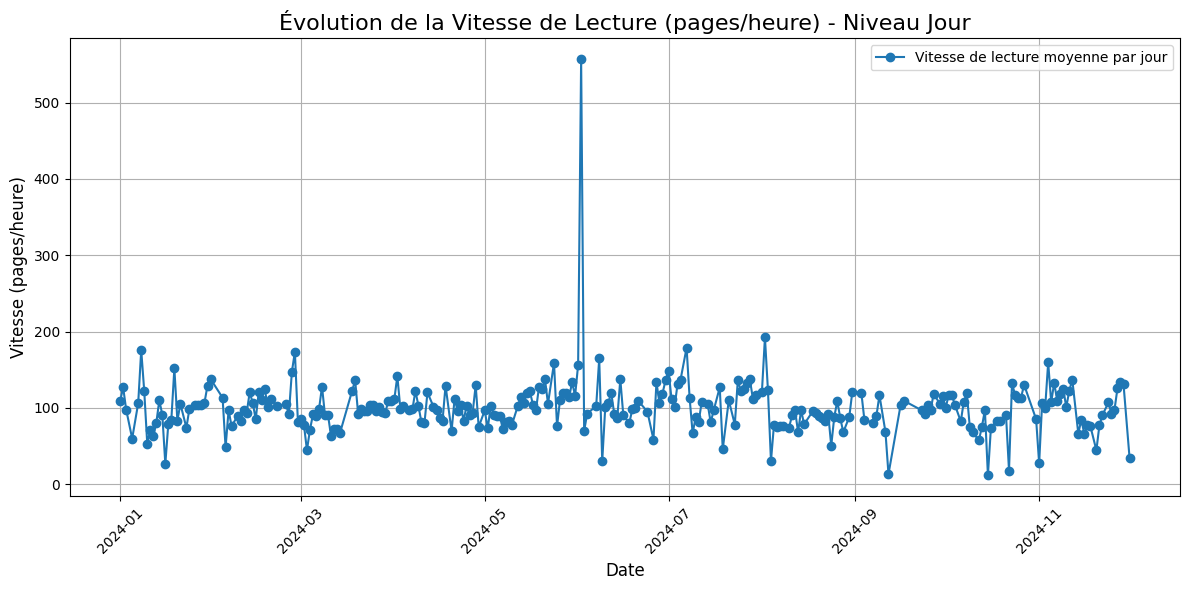

In [35]:
import matplotlib.pyplot as plt

# Agrégation globale par jour (date lecture)
daily_speed = grouped.groupby('date lecture', as_index=False).agg({
    'vitesse (pages/heure)': 'mean'  # Moyenne des vitesses pour toutes les pages et livres
})

# Tracé
plt.figure(figsize=(12, 6))
plt.plot(
    daily_speed['date lecture'],
    daily_speed['vitesse (pages/heure)'],
    marker='o',
    label='Vitesse de lecture moyenne par jour'
)

# Ajouter des détails au graphique
plt.title("Évolution de la Vitesse de Lecture (pages/heure) - Niveau Jour", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Vitesse (pages/heure)", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Afficher le graphique
plt.show()


In [27]:
sorted_df = grouped.sort_values(by='vitesse (pages/heure)', ascending=False)
sorted_df.head(40)

,id_book,page,année_mois,Temps passé sur la page en seconde,id_long,date lecture,heure de début,Temps total en minutes,vitesse (pages/minute),vitesse (pages/heure)
1054,8,17,2024-01,6,00008,2024-01-08,2024-01-08 01:05:52,0.1,10.0,600.0
1008,5,557,2024-01,6,00005,2024-01-08,2024-01-08 00:08:09,0.1,10.0,600.0
18684,78,287,2024-11,6,00078,2024-11-29,2024-11-29 17:33:51,0.1,10.0,600.0
1066,8,187,2024-01,6,00008,2024-01-08,2024-01-08 01:05:02,0.1,10.0,600.0
1069,8,700,2024-01,6,00008,2024-01-08,2024-01-08 01:06:57,0.1,10.0,600.0
1076,13,9,2024-01,6,00013,2024-01-09,2024-01-09 11:30:38,0.1,10.0,600.0
1073,8,721,2024-01,6,00008,2024-01-08,2024-01-08 01:08:19,0.1,10.0,600.0
17748,73,491,2024-11,6,00073,2024-11-12,2024-11-12 00:42:37,0.1,10.0,600.0
95,2,107,2023-11,6,00002,2023-11-23,2023-11-23 09:02:13,0.1,10.0,600.0
1327,16,289,2024-01,6,00016,2024-01-14,2024-01-14 23:32:21,0.1,10.0,600.0


In [74]:
# Regrouper par date lecture
daily_speed = grouped.groupby('date lecture', as_index=False).agg({
    'page': lambda x: x.nunique(),  # Nombre de pages uniques lues
    'Temps passé sur la page en seconde': 'sum'  # Temps total passé en secondes
})

# Calcul de la vitesse moyenne journalière
daily_speed['vitesse moyenne (pages/heure)'] = daily_speed['page'] / (daily_speed['Temps passé sur la page en seconde'] / 3600)

# Trier par vitesse décroissante pour identifier les anomalies
sorted_daily_speed = daily_speed.sort_values(by='vitesse moyenne (pages/heure)', ascending=False)


# Joindre les titres des livres au top_days_with_books
top_days_with_titles = top_days_with_books.merge(
    df_book_updated[['id', 'Titre']],  # Garder uniquement les colonnes nécessaires
    left_on='id_book',
    right_on='id',
    how='left'
)


worst_days_with_titles = worst_days.merge(
    grouped[['date lecture', 'id_book']],  # Ajouter l'ID du livre
    on='date lecture',
    how='left'
).merge(
    df_book_updated[['id', 'Titre']],
    left_on='id_book',
    right_on='id',
    how='left'
)

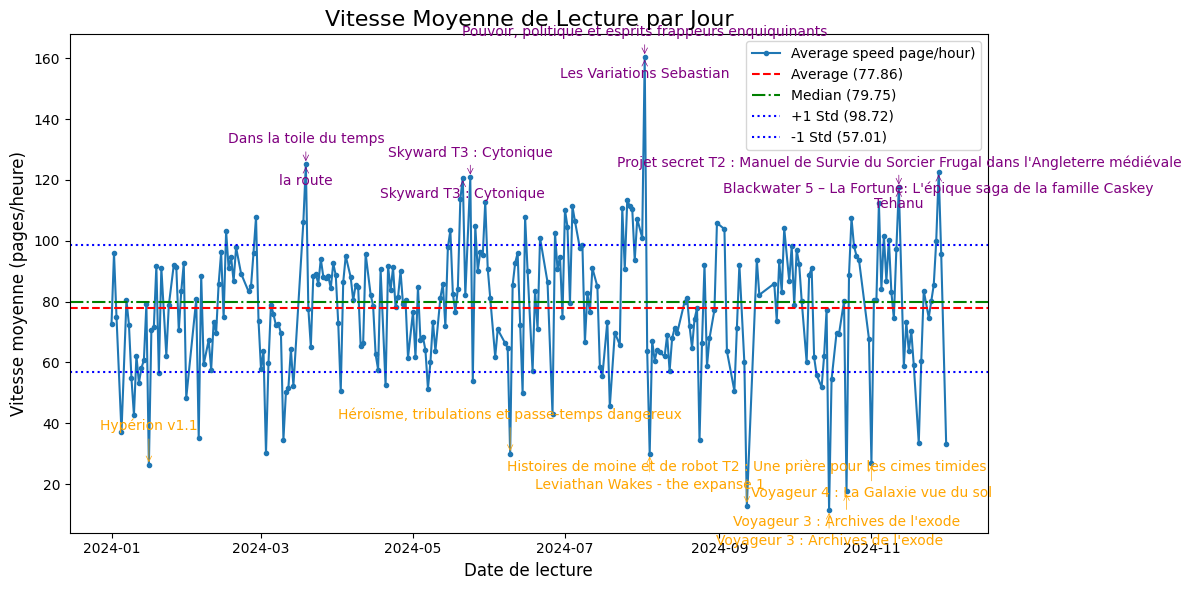

In [79]:
# Supprimer les lignes avec une vitesse moyenne < 250
filtered_daily_speed = daily_speed[daily_speed['vitesse moyenne (pages/heure)'] <= 220]

mean_speed = filtered_daily_speed['vitesse moyenne (pages/heure)'].mean()
median_speed = filtered_daily_speed['vitesse moyenne (pages/heure)'].median()
std_speed = filtered_daily_speed['vitesse moyenne (pages/heure)'].std()
top_speeds = filtered_daily_speed.nlargest(3, 'vitesse moyenne (pages/heure)')
top_days = daily_speed.nlargest(4, 'vitesse moyenne (pages/heure)')[['date lecture', 'vitesse moyenne (pages/heure)']]
worst_days = daily_speed.nsmallest(4, 'vitesse moyenne (pages/heure)')[['date lecture', 'vitesse moyenne (pages/heure)']]


# Étape 2 : Associer id_book à ces journées
top_days_with_books = top_days.merge(
    grouped[['date lecture', 'id_book']].drop_duplicates(),  # Récupérer les ids uniques
    on='date lecture',
    how='left'
)




# # Étape 2 : Associer id_book à ces journées
# worst_days_with_books = worst_days.merge(
#     grouped[['date lecture', 'id_book']].drop_duplicates(),  # Récupérer les ids uniques
#     on='date lecture',
#     how='left'
# )

# Tracé de la vitesse moyenne journalière après suppression des anomalies
plt.figure(figsize=(12, 6))
plt.plot(
    filtered_daily_speed['date lecture'],
    filtered_daily_speed['vitesse moyenne (pages/heure)'],
    marker='.',
    label='Average speed page/hour)'
)

# Ajouter des lignes horizontales pour les statistiques
plt.axhline(y=mean_speed, color='red', linestyle='--', label=f'Average ({mean_speed:.2f})')
plt.axhline(y=median_speed, color='green', linestyle='-.', label=f'Median ({median_speed:.2f})')
plt.axhline(y=mean_speed + std_speed, color='blue', linestyle=':', label=f'+1 Std ({(mean_speed + std_speed):.2f})')
plt.axhline(y=mean_speed - std_speed, color='blue', linestyle=':', label=f'-1 Std ({(mean_speed - std_speed):.2f})')

# Annoter les 3 vitesses les plus élevées avec des positions dynamiques
for i, row in enumerate(top_days_with_titles.iterrows()):
    _, row = row
    date = row['date lecture']
    speed = row['vitesse moyenne (pages/heure)']
    title = row['Titre']
    
    # Calcul d'un offset vertical différent pour éviter les chevauchements
    vertical_offset = 15 if i % 2 == 0 else -15  # Alterner les directions
    
    plt.annotate(
        f"{title}",
        (date, speed),
        textcoords="offset points",
        xytext=(0, vertical_offset),  # Décalage vertical dynamique
        ha='center',
        fontsize=10,
        color='purple',
        arrowprops=dict(arrowstyle="->", color="purple", lw=0.5)  # Optionnel : ajouter une flèche
    )

# Annoter les jours avec les vitesses les plus lentes
for i, row in enumerate(worst_days_with_titles.iterrows()):
    _, row = row
    date = row['date lecture']
    speed = row['vitesse moyenne (pages/heure)']
    title = row['Titre']
    
    vertical_offset = -25 if i % 2 == 0 else 25
    plt.annotate(
        f"{title}",
        (date, speed),
        textcoords="offset points",
        xytext=(0, vertical_offset),
        ha='center',
        fontsize=10,
        color='orange',
        arrowprops=dict(arrowstyle="->", color="orange", lw=0.5)
    )


# Ajouter des détails au graphique
plt.title("Vitesse Moyenne de Lecture par Jour", fontsize=16)
plt.xlabel("Date de lecture", fontsize=12)
plt.ylabel("Vitesse moyenne (pages/heure)", fontsize=12)
plt.grid(False)
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()

# Afficher le graphique
plt.show()


# Nombre de pages lues en moyenne par jour

In [86]:
df_book_updated = pd.read_parquet("../data_sources_from_python/df_book_updated.parquet")
# df_book_streamlit = pd.read_parquet("df_book_streamlit.parquet")
df_stat = pd.read_parquet("../data_sources_from_python/stats_lecture.parquet")
# préparer df_book_updated pour le filtre : 
df_book_updated['Date de lecture'] = pd.to_datetime(df_book_updated['Date de lecture'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df_stat['Date de lecture en jour'] = pd.to_datetime(df_stat['date lecture'], format="%Y-%m-%d")

In [87]:
# group by df_stat par date de lecture en jour, puis somme Temps passé sur la page en seconde
daily_reading_time = df_stat.groupby('Date de lecture en jour')['Temps passé sur la page en seconde'].sum().reset_index()
daily_reading_time['Temps passé sur la page en minute'] = daily_reading_time['Temps passé sur la page en seconde'] / 60
daily_reading_time['Temps passé sur la page en heure'] = daily_reading_time['Temps passé sur la page en minute'] / 60

In [91]:
df_stat.tail(1)

,id_book,page,heure de début,Temps passé sur la page en seconde,total_pages,id_long,Temps de lecture en minute,Temps de lecture en heure,date lecture,Heure de début de lecture,Heure,Heure en décimal,Jour Précédent,Est Consécutif,date de fin de lecture,Titre,Auteurs,Date de lecture en jour
20714,79,357,2024-12-04 20:35:00,49,515,00079,0.816667,0.013611,2024-12-04,20:35:00,20,20.583333,2024-12-03,True,2024-12-04,Sagas & sable d’os : Une histoire du Légendes ...,Travis Baldtree,2024-12-04


In [88]:
daily_reading_time.tail()

,Date de lecture en jour,Temps passé sur la page en seconde,Temps passé sur la page en minute,Temps passé sur la page en heure
288,2024-11-29,3380,56.333333,0.938889
289,2024-12-01,1008,16.800000,0.280000
290,2024-12-02,6366,106.100000,1.768333
291,2024-12-03,3357,55.950000,0.932500
292,2024-12-04,3315,55.250000,0.920833


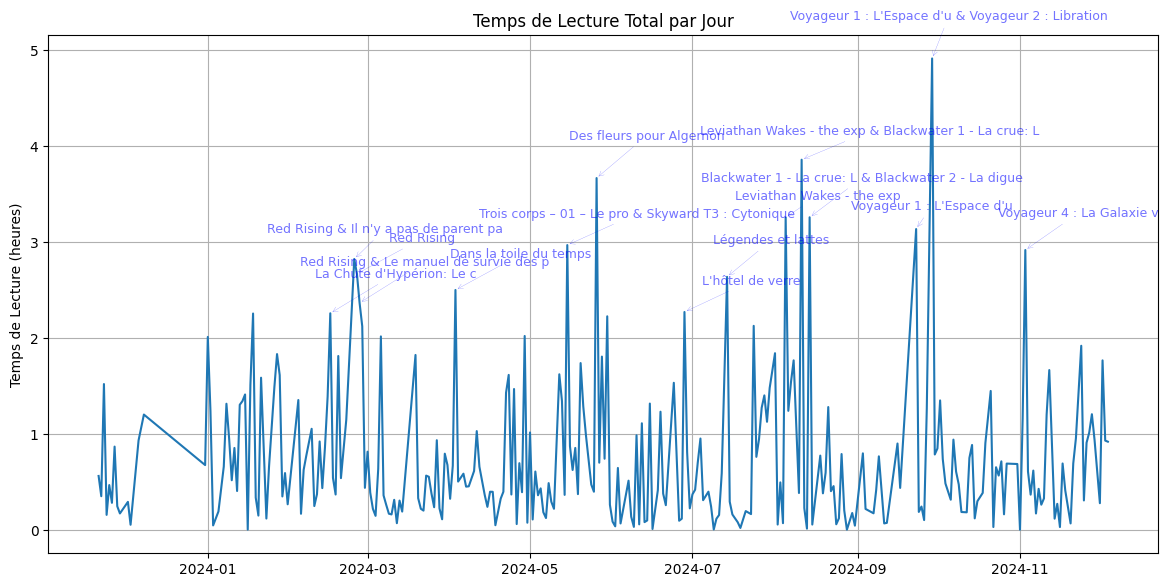

In [104]:
import random
# ajoute annotation : titre des 5 jours avec le plus de lecture, si il y a plusieurs livre, affiche le premier
top_days = daily_reading_time.nlargest(15, 'Temps passé sur la page en heure')

top_days_with_books = top_days.merge(
    df_stat[['Date de lecture en jour', 'id_book', 'Titre']].drop_duplicates(),
    left_on='Date de lecture en jour',
    right_on='Date de lecture en jour',
    how='left'
)
# créer une colonne titre_court, reprend uniquement les 10 premiers caractères de Titre
top_days_with_books['Titre_court'] = top_days_with_books['Titre'].str[:25]
# créer une colonne titre_court, reprend uniquement les mots de plus de 4 lettres et les chiffres
# top_days_with_books['Titre_court'] = top_days_with_books['Titre'].str.findall(r'\b\w{4,}\b').str.join(' ')



# new
top_days_with_books['Titre_concatené'] = top_days_with_books.groupby('Date de lecture en jour')['Titre_court'].transform(lambda x: ' & '.join(x))
top_days_with_books_unique = top_days_with_books.drop_duplicates(subset=['Date de lecture en jour'])




# top_days_with_books = top_days_with_books.sort_values(by='Date de lecture en jour').drop_duplicates(subset=['Date de lecture en jour'])

# plot daily_reading_time sur un line chart
plt.figure(figsize=(12, 6))
plt.plot(daily_reading_time['Date de lecture en jour'], daily_reading_time['Temps passé sur la page en heure'], marker='')

# Ajouter des annotations pour les 5 jours avec le plus de lecture
for i, row in top_days_with_books_unique .iterrows():
    date = row['Date de lecture en jour']
    time_spent = row['Temps passé sur la page en heure']
    title = row['Titre_concatené']

        # Créer un offset aléatoire
    offset_x = random.randint(10, 50)  # Décalage horizontal entre 10 et 50
    offset_y = random.randint(10, 30)  # Décalage vertical entre 10 et 30
    
    plt.annotate(
        f"{title}",
        (date, time_spent),
        textcoords="offset points",
        xytext=(offset_x, offset_y),  # Décalage vertical
        ha='center',
        fontsize=9,
        color='blue',
        # rotation=30,
        # ajouter transparence texte
        alpha=0.55,
        arrowprops=dict(arrowstyle="->", color="blue", lw=0.1)  # Optionnel : ajouter une flèche
    )

plt.title('Temps de Lecture Total par Jour')
plt.ylabel('Temps de Lecture (heures)')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()


plt.show()

